In [67]:
import dateutil.parser
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            
sns.set()

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize,optimize,least_squares 

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

import warnings                                 
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw
import statsmodels.tsa
from scipy.spatial.distance import pdist, squareform
%matplotlib inline


In this notebook, we are analyzing two hashtags #moiAussi and #balancetonporc, which are the equivalent hashtags of #metoo movement. Through the analysis of two hashtags that are related to the same phenomenon, we would like to provide a pipeline for analyzing twitter hashtags, and finding distinguishing hashtags related to the same phenomena by finding similarities in their time series. We decided to focus on only two hashtags, because of the large scale of twitter dataset, which wouldn't allow us the time to compare every two hashtags.

In [15]:
df = pd.read_json('balancetonporc.json',lines = True)

In [4]:
print(df.columns)

Index(['conversation_id', 'created_at', 'date', 'gif_thumb', 'gif_url',
       'has_parent_tweet', 'hashtags', 'id', 'is_quote_status', 'is_reply_to',
       'likes_count', 'link', 'location', 'mentions', 'name', 'photos',
       'place', 'quote_id', 'quote_url', 'replies', 'replies_count', 'retweet',
       'retweets_count', 'tags', 'time', 'timezone', 'tweet', 'urls',
       'user_id', 'username', 'video_thumb', 'video_url'],
      dtype='object')


In [5]:
df.head(5)

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweets_count,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url
0,1071507278875033600,2018-12-08 20:50:17,2018-12-08,,,0,[#balancetonporc],1071507278875033600,0,0,...,0,[],21:50:17,CET,Un livreur de pizza qui demande clairement des...,[],777095708692324353,hllelea,,
1,1071495065514721280,2018-12-08 20:01:45,2018-12-08,,,0,[#balancetonporc],1071495065514721280,0,0,...,0,[],21:01:45,CET,J'ai ajouté une vidéo à une playlist @YouTube ...,[http://youtu.be/QYAYnGu_iaw?a],830093777591234560,chouchoue_,,
2,1071483541286993920,2018-12-08 19:15:58,2018-12-08,,,0,[#balancetonporc],1071483541286993920,0,0,...,0,[],20:15:58,CET,#balancetonporc https://www.sudouest.fr/2018/...,[https://www.sudouest.fr/2018/09/05/il-photogr...,882276333291786240,sweetieoparadis,,
3,1071481275528167424,2018-12-08 19:06:57,2018-12-08,,,0,[#balancetonporc],1071481275528167425,0,0,...,0,[],20:06:57,CET,Salut la twitosphère #balancetonporc,[],1042521930849570816,duhippolyte,,
4,1071468524571451392,2018-12-08 18:16:17,2018-12-08,,,0,"[#balancetonporc, #balanceta2000]",1071468524571451392,0,0,...,0,[],19:16:17,CET,Après #balancetonporc il y a #balanceta2000 @L...,[],1065703994,alex____torres_,,


In [3]:
def create_timedate(df):
    
    # merge date and time into a datetime column
    
    df['timedate'] = list(map(lambda el: el[:10]+' ',list(map(str,df.loc[:,'date'])))) + df.loc[:,'time']
    
    df['timedate'] = df['timedate'].apply(lambda t: dateutil.parser.parse(t))
    
    # Sets index of dataframe to datetime in order to perform time series analysis

    df = df.set_index('timedate') 
    return df

In [2]:
def countby_upto(t,df):
    
    '''
    Input:
        t - a number from 0 t0 5, where 0 indicates that we should consider timedate up to its seconds unit
        df - dataframe
    Output:
        dataframe with a datetime index in order to perform our time series analysis
        
    '''
    
    df1 = df.copy()
    df1['timedate'] = list(map(lambda el: el[:-3 * time_to_num[t]],list(map(str,df1.index))))
    return df1.groupby(df1['timedate']).size().reset_index().rename(columns = {0:'count'}).set_index('timedate')

In [1]:
tmp = [('second',0),('minute',1),('hour',2),('day',3),('month',4),('year',5)]
time_to_num = dict(tmp)

In [16]:
df = create_timedate(df)

# We will analyze tweets on an hourly basis
df1 = countby_upto('hour',df)

We use pandas implementation DataFrame.rolling(window).mean() to smooth the original timeseries in order to identify trends. The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [6]:
data = pd.read_json('./moi/tweets.json',lines = True)

In [7]:
data = create_timedate(data)
data1 = countby_upto('hour',data)

In [12]:
print('The hashtag #balancetonparc was first tweeted at {0}'.format(min(df.index)))
print('The hashtag #balancetonparc was last tweeted at {0}'.format(max(df.index)))
print('The hashtag #moiaussi was first tweeted at {0}'.format(min(data.index)))
print('The hashtag #moiaussi was last tweeted at {0}'.format(max(data.index)))

The hashtag #balancetonparc was first tweeted at 2017-10-13 14:06:32
The hashtag #balancetonparc was last tweeted at 2018-12-08 21:50:17
The hashtag #moiaussi was first tweeted at 2009-07-02 12:05:36
The hashtag #moiaussi was last tweeted at 2018-12-16 01:26:24


We can see that some of the extracted tweets for the #moiaussi hashtag date back to 2009, and we assume that these data 
are not of interest for us, because we are interested in extracting the tweets with the #moiaussi hashtag that are related to the metoo movement, and hence to balancetonporc. However, we noticed that many of the tweets that contain the #moiaussi hashtag also contain the metoo hashtag, so we thought we could extract the data of interest by filtering tweets that contain both hashtags.

In [8]:
tmp = data[data['hashtags'].apply(lambda el: '#moiaussi' in el and '#metoo' in el)]

In [14]:
len(tmp) - len(tmp[tmp.index >= dateutil.parser.parse('2017-10-13 14:06:32')])

44

We still observe a big difference in starting date for both hashtags (about 6 years). In order to further filter the necessary data and avoid analyzing the differences resulting from such difference, we only consider the tweets from the #moiaussi hashtag that have a starting time of at least equal to the balancetonporc hashtag.

In [15]:
max_tweet1 = df[str(np.argmax((df.loc[:,'retweets_count'])))]
max_tweet2 = data[str(np.argmax((data.loc[:,'retweets_count'])))]

In [16]:
max_tweet1['retweets_count']

timedate
2017-10-31 12:10:14    20351
Name: retweets_count, dtype: int64

In [17]:
max_tweet2['retweets_count']

timedate
2017-10-19 22:48:25    511
2017-10-19 22:48:25    511
Name: retweets_count, dtype: int64

We obtained two rows for the 2nd hashtag, but we notice that it is just the same data duplicated. After analyzing the most retweeted tweets for the two hashtags, we also noticed that they are very close to one another in the timeline, which also corresponds to the date when the metoo movement gained traction. Also, as confirmed by our graphs,the number of retweets for the first hashtag is almost twice the number of retweets for the 2nd hashtag. This data is also supported by a larger number of sexual harrasment cases in France compared to Canada. The higher number of retweets of the tweets with the given hashtag is also supported by an average of around 4 retweets per user for the #balancetonporc case compared to a mean of 1 retweet per user for the #moiAussi hashtag.

In [18]:
retweet_mean1 = (df['retweets_count'].sum())/len(df)
retweet_mean2 = (data['retweets_count'].sum())/len(data)

In [19]:
print('mean retweet count for #balancetonporc is {0} and for #moiAussi is {1}'.format(retweet_mean1,retweet_mean2))

mean retweet count for #balancetonporc is 4.715217056757929 and for #moiAussi is 1.101981234647445


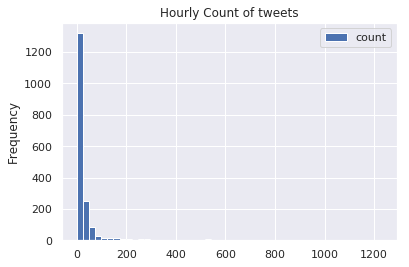

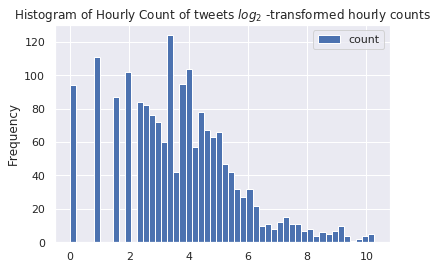

In [ ]:
df1.plot.hist(bins=50, title="Hourly Count of tweets");
np.log2(df1).plot.hist(bins=50,
                      title="Histogram of Hourly Count of tweets $log_2$ -transformed hourly counts");

In [11]:
def plotMovingAverage(series, window,scale=1.96,anomalies = False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    if anomalies == True:
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        anomalies[series<lower_bond] = series[series<lower_bond]
        anomalies[series>upper_bond] = series[series>upper_bond]
        plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    

In [36]:
def get_anomalies(series, window,scale=1.96):
    
    rolling_mean = series.rolling(window=window).mean()
    
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    
    # drop the values outside the window size
    return anomalies.dropna()

A low smoothing factor means that our smoothed (detrended) data will have a high variance, while a high smoothing factor will result in a low variance, high bias, but it will enable us to better analyze a spike. A smoothing factor of 1 will result in the graph itself.

In [13]:
def standardize(df): 
    return (df - df.mean()) / df.std()


From the plot of standardized twitter counts, we can clearly observe that there is a spike in the beginning, because of the attention that this movement (metoo) attracted at the time, and with time, the number of tweets falls drastically and doesn't change by a large margin in an hourly basis

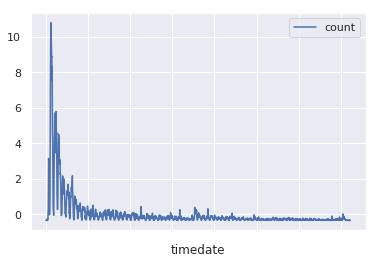

In [ ]:
standardize(df1).plot()

The method below is used to plot some normal data with standard deviation = 1 and mean = 0 and compare it with our data
in order to check whether our data is normalized or not

In [ ]:
def gen_normal_plot(df):
    
    plt.plot(df.index.values,
             np.random.normal(size=df.shape[0]),
             lw=0.8,
             alpha=0.75)
    
    plt.ylim((-5, 5))
    plt.title("Generated normal time series with $\sigma$ bands")

    plt.axhline(y=1, color="red")
    plt.axhline(y=-1, color="red")

    arrowprops = dict(arrowstyle="-",
                      color="black",
                      lw=2)

    plt.annotate("$\sigma$",
                 xy=(df.index.values[1000], 1),
                 xytext=(df.index.values[1000], -1.5),
                 arrowprops=arrowprops)

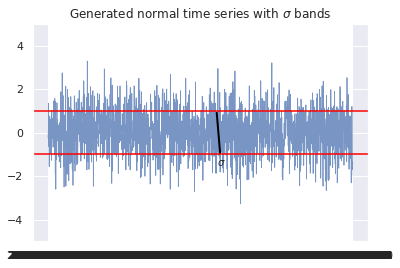

In [ ]:
gen_normal_plot(df1)

As we can see, the distribution of the hourly count of tweets falls outside the $[-\sigma,\sigma]$ range, 
where $\sigma$ denotes the standard deviation, supporting our previous observation that the data is skewed, which
is not anomaly in this case, because clearly the number of tweets with a given hashtag will be very high when a hashtag
initially emerges, but as this popularity is ephemeral, the number of tweets will soon approach 0.

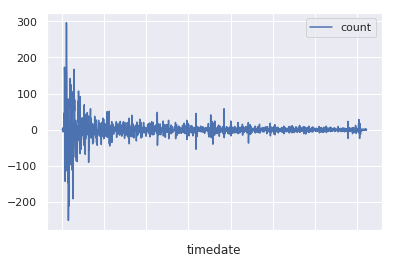

In [ ]:
df1.diff().plot()

The above graph clearly demonstrates the huge difference in counts when the twitter first gains traction, and then when
it dissapears into obscurity.

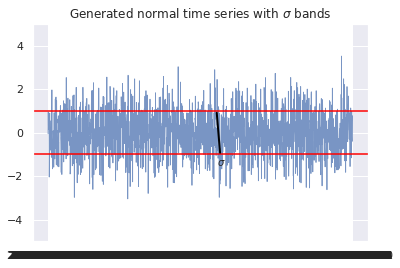

In [ ]:
gen_normal_plot(standardize(np.log2(df1)))

Log transformation before standardization helps give more reasonable standardized values, even if the log-transform isn't quite enough to make this data normal

We will now use the plotMovingAverage function to plot the daily trends in tweets, and see how the actual trend in a tweet compares with the normal one. In order to get the daily trend, we set the moving window to 24h. This parameter
can be changed to any number, but it will afect the smoothed graph. A small number will produce a graph with a low bias,
while a large number, will produce a graph with high variance.

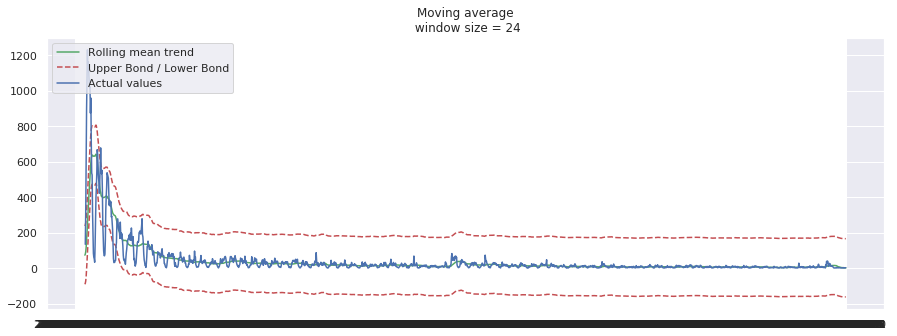

In [ ]:
# Get the daily trend
plotMovingAverage(df1,24)

From the above graph, we can observe that the data follows the expected daily trend, i.e., the smoothed data almost perfectly fits our normal data. We can also plot the confidence interval, to see how confident we should be in the correctness of our smoothed data.

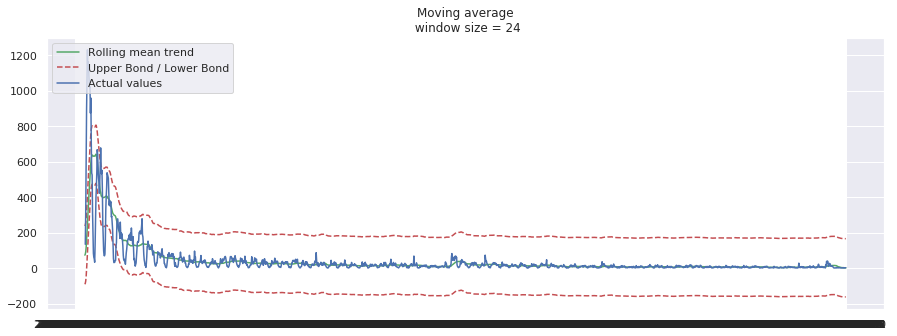

In [ ]:
plotMovingAverage(df1,24)

In order to detect deviations from the expected trend, we set plot_anomalies to true 

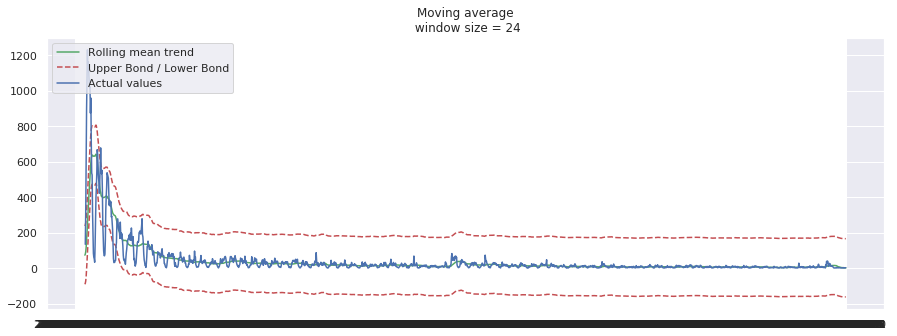

In [40]:
plotMovingAverage(data1,24,anomalies = True)

The above model of rolling window is way too simplistic and it doesn't account for trends and seasons in our data, although it can be used as a baseline. A more complex model is needed to account for seasons and trends in our data, and we found Holt-Winters to be one such model.

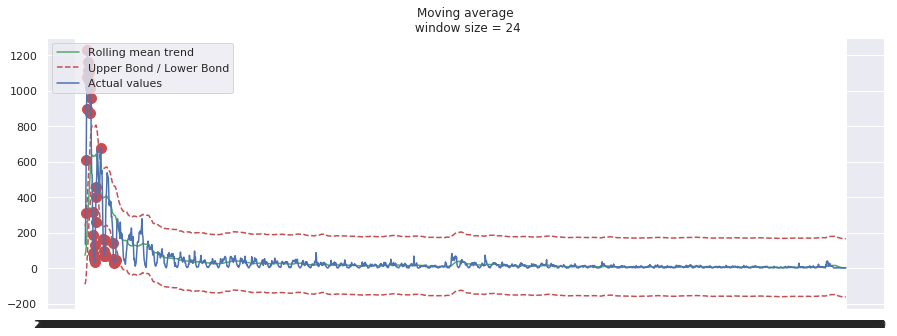

In [ ]:
plotMovingAverage(df1,24,anomalies = True)

In [ ]:
plotMovingAverage(data1,24,anomalies = True)

The plots obtained from the rolling window method seem to reject our hypothesis that the two hashtags follow a similar pattern of time spread on an hourly basis. In order to further investigate the reasons for such difference we first try to look at the timeline for both the hashtags.

In [9]:
tmp = tmp[tmp.index >= dateutil.parser.parse('2017-10-13 14:06:32')]

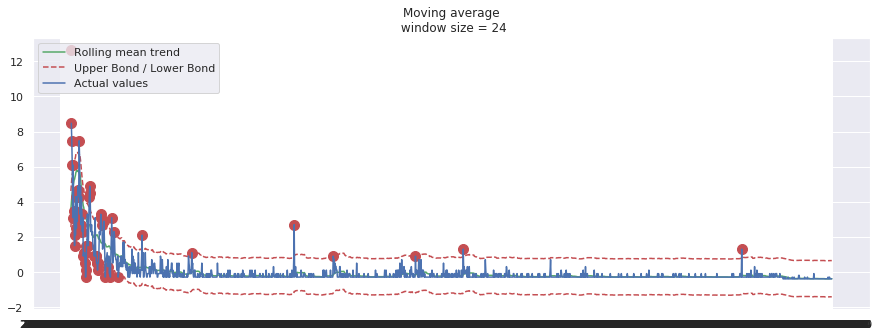

In [14]:
plotMovingAverage(standardize(countby_upto('hour',tmp)),24,anomalies = True)

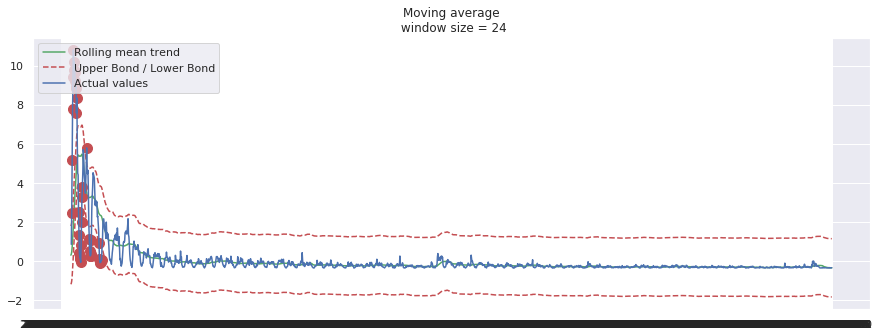

In [18]:
plotMovingAverage(standardize(df1),24,anomalies = True)

We can now clearly see that both time series follow a very similar pattern, with very similar "anomalies" and spikes, although the amplitude of the spikes is different, which is expected given their popularity in different geographical areas. The notion of difference in time series is formalized by applying the dynamic time warping algorithm.

In [77]:
# A list of tuple of (hour, number of occurrences of tweets) for anomalies

dist1= list(zip(list(map(int,anomalies1.values)),list(map(lambda el:el.hour,list(map(dateutil.parser.parse,anomalies1.index))))))

dist2= list(zip(list(map(int,anomalies2.values)),list(map(lambda el:el.hour,list(map(dateutil.parser.parse,anomalies2.index))))))

In [71]:
anomalies1 = get_anomalies(df1,24)
anomalies2 = get_anomalies(data1,24)

In [78]:
x = np.array(dist1)
y = np.array(dist2)
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

55152.38366431613


The reason that we only use anomalies to compute dtw in this case is because the progression of anomalies best captures the distance between two time series. For example, suppose we have three time series t1, t2 and t3 such that t2 and t3 are related, t1 and t2 are related, but t1 and t3 are not. Hence, t2 may have some anomalies that are related to the events modeled by t3, which will be missing in t1. Hence, if we consider every point, it is likey that we'll conclude that t1 and t2 are not related. However, by only measuring the distance between anomalies, we can capture the relation between t1 and t2 by ignoring certain events which are modeled by t2 and are related to t3. 